# Computer vision Final project

Authors: TBD

Fetch data

In [ ]:
!wget -nc http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar
!tar -xf VOCtrainval_11-May-2009.tar --totals

voc_root_folder = "/content/VOCdevkit/VOC2009"
!ls "VOCdevkit/VOC2009"

--2020-05-30 16:04:04--  http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 935534080 (892M) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2009.tar’

VOCtrainval_11-May- 100%[===================>] 892.19M  12.6MB/s    in 74s     

2020-05-30 16:05:18 (12.0 MB/s) - ‘VOCtrainval_11-May-2009.tar’ saved [935534080/935534080]

Total bytes read: 935536640 (893MiB, 243MiB/s)
Annotations  ImageSets	JPEGImages  SegmentationClass  SegmentationObject


In [ ]:
import os, sys
import numpy as np
from PIL import Image
import random
import cv2

import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D,Dense,Flatten,add,BatchNormalization,Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# train test size vs val test size is approx 50% vs. 50%
class Dataset:
    def __init__(self):
        self.classes = ['person', 'bird', 'cat', 'cow', 'dog',
                        'horse', 'sheep', 'aeroplane', 'bicycle',
                        'boat', 'bus', 'car', 'motorbike', 
                        'train', 'bottle', 'chair', 'diningtable',
                        'pottedplant', 'sofa', 'tvmonitor']

        self.class2id = {c: i for i, c in enumerate(self.classes)}

        self.img_set_main_path = "VOCdevkit/VOC2009/ImageSets/Main/"
        self.img_set_seg_path = "VOCdevkit/VOC2009/ImageSets/Segmentation/"
        self.jpeg_img_path = "VOCdevkit/VOC2009/JPEGImages/"
        self.seg_class_path = "VOCdevkit/VOC2009/SegmentationClass/"
        
        self.train_files_cl = [i.strip() for i in open(os.path.join(self.img_set_main_path, 'train.txt'), 'r')]
        self.val_files_cl = [i.strip() for i in open(os.path.join(self.img_set_main_path, 'val.txt'), 'r')]
        self.test_files_cl = []

        self.train_files_seg = [i.strip() for i in open(os.path.join(self.img_set_seg_path, 'train.txt'), 'r')]
        self.val_files_seg = [i.strip() for i in open(os.path.join(self.img_set_seg_path, 'val.txt'), 'r')]
        self.test_files_seg = []

        print("Reading classification data...")
        self.train_data_cl = {}
        for c in self.classes:
            with open(self.img_set_main_path + c + '_train.txt', 'r') as f:
                for line in f:
                    tmp = line.split()
                    img_id, present = tmp[0].strip(), tmp[1].strip()
                    if img_id not in self.train_data_cl:
                        self.train_data_cl[img_id] = {}
                        self.train_data_cl[img_id]['y'] = np.array([0]*20, dtype=np.int8)  # create vector with labels
                        self.train_data_cl[img_id]['X'] = np.array(Image.open(self.jpeg_img_path + img_id + ".jpg"))
                    if present == '1':  # if a given class is present in the image change label to 1
                        self.train_data_cl[img_id]['y'][self.class2id[c]] = 1

        self.val_data_cl, self.test_data_cl = {}, {}
        for c in self.classes:
            tmp = [(i.split()[0].strip(), i.split()[1].strip()) for i in open(self.img_set_main_path + c + '_val.txt', 'r')]
            for i, (img_id, present) in enumerate(tmp):
                    if img_id not in self.val_data_cl:
                        self.val_data_cl[img_id] = {} 
                        self.val_data_cl[img_id]['y'] = np.array([0]*20, dtype=np.int8)  # create vector with labels
                        self.val_data_cl[img_id]['X'] = np.array(Image.open(self.jpeg_img_path + img_id + ".jpg"))
                    if present == '1':  # if a given class is present in the image change label to 1
                        self.val_data_cl[img_id]['y'][self.class2id[c]] = 1
 
    def to_numpy(self, task, target_size, preprocess=False):
        if task in ['cl', 'c', 'classification', 'class']:
            X_train, y_train = np.zeros((len(self.train_data_cl), target_size[0], target_size[1], target_size[2]), dtype=np.float32), np.zeros((len(self.train_data_cl), 20), dtype=np.int8)
            X_val, y_val = np.zeros((len(self.val_data_cl), target_size[0], target_size[1], target_size[2]), dtype=np.float32), np.zeros((len(self.val_data_cl), 20), dtype=np.int8)

            if preprocess:
                for i, key in enumerate(self.train_data_cl):
                    X_train[i] = preprocess_input(cv2.resize(self.train_data_cl[key]['X'], (target_size[0], target_size[1]), interpolation=cv2.INTER_LINEAR), 'channels_last','torch')
                    y_train[i] = self.train_data_cl[key]['y']
                for i, key in enumerate(self.val_data_cl):
                    X_val[i] = preprocess_input(cv2.resize(self.val_data_cl[key]['X'], (target_size[0], target_size[1]), interpolation=cv2.INTER_LINEAR),'channels_last','torch')
                    y_val[i] = self.val_data_cl[key]['y']
            else:
                for i, key in enumerate(self.train_data_cl):
                    X_train[i] = cv2.resize(self.train_data_cl[key]['X'], (target_size[0], target_size[1]), interpolation=cv2.INTER_LINEAR) / 255.
                    y_train[i] = self.train_data_cl[key]['y']
                for i, key in enumerate(self.val_data_cl):
                    X_val[i] = cv2.resize(self.val_data_cl[key]['X'], (target_size[0], target_size[1]), interpolation=cv2.INTER_LINEAR) / 255.
                    y_val[i] = self.val_data_cl[key]['y']

            return X_train, y_train, X_val, y_val              

def preprocess(img):
    return (preprocess_input(img, mode='tf')+1)/2

def reconstruct(x):
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    return (x*std)+mean

def get_src_trg_keys(scr_class, trg_class, set='validation'):
  src_id = D.class2id[src_class]
  trg_id = D.class2id[trg_class]

  if set=='validation':
    src_keys = [key for index, key in enumerate(D.val_data_cl) if len(np.where(D.val_data_cl[key]['y'])[0])==1 and np.where(D.val_data_cl[key]['y'])[0][0]==src_id]
    trg_keys = [key for index, key in enumerate(D.val_data_cl) if len(np.where(D.val_data_cl[key]['y'])[0])==1 and np.where(D.val_data_cl[key]['y'])[0][0]==trg_id]

  elif set=='training':
    src_keys = [key for index, key in enumerate(D.train_data_cl) if len(np.where(D.train_data_cl[key]['y'])[0])==1 and np.where(D.train_data_cl[key]['y'])[0][0]==src_id]
    trg_keys = [key for index, key in enumerate(D.train_data_cl) if len(np.where(D.train_data_cl[key]['y'])[0])==1 and np.where(D.train_data_cl[key]['y'])[0][0]==trg_id]

  return src_keys, trg_keys


# CREATE DATASET
D = Dataset()

Reading classification data...


**Mount Shared Google Drive folder**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

sys.path.append('/content/drive/My Drive/CV3_Deep_Learning_files/')

print('\nFiles in the shared folder on the drive: \n')
%ls '/content/drive/My Drive/CV3_Deep_Learning_files/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/

Files in the shared folder on the drive: 

AE_mm_augm_hist.npy
AE_mm_hist.npy
autoencoder76_AE_hist.npy
autoencoder_AE_hist.npy
autoencoder_augm_AE_hist.npy
mm_augm_hist_v01.npy
model.png
model_weights_AE_mm_augm.h5
model_weights_AE_mm.h5
model_weights_autoencoder76_AE.h5
model_weights_autoencoder_AE.h5
model_weights_autoencoder_augm_AE.h5
model_weights_SCRATCH_segm_vanilla_augm.h5
model_weights_SCRATCH_segm_vanilla.h5
model_weights_TL_cl_valF1_77_light.h5
m

## Classification


Extract Classification Data Sets

In [ ]:
X_train, y_train, X_val, y_val = D.to_numpy('cl', (224,224,3), True)         # Convert to np array with preprocessing_input

print(np.max(X_train))
print(np.min(X_train))

print(np.max(X_val))
print(np.min(X_val))

2.64
-2.117904
2.64
-2.117904


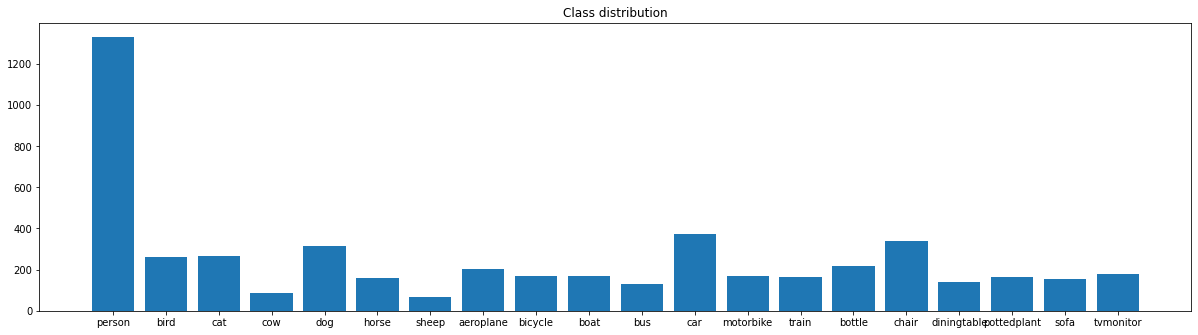

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,4))
ax = fig.add_axes([0,0,1,1])
ax.bar(D.classes, np.sum(y_train, axis=0))
plt.title('Class distribution')
plt.show()

### Classification transfer learning

### Adversarial Examples (Preliminary Visualization - Fast Gradient Sign method):

**Define Source and Target class:**

In [ ]:
print(D.class2id)

{'person': 0, 'bird': 1, 'cat': 2, 'cow': 3, 'dog': 4, 'horse': 5, 'sheep': 6, 'aeroplane': 7, 'bicycle': 8, 'boat': 9, 'bus': 10, 'car': 11, 'motorbike': 12, 'train': 13, 'bottle': 14, 'chair': 15, 'diningtable': 16, 'pottedplant': 17, 'sofa': 18, 'tvmonitor': 19}


In [ ]:
src_class = 'aeroplane'
trg_class = 'boat'

In [ ]:
src_keys, trg_keys = get_src_trg_keys(src_class, trg_class, 'validation')

print(len(src_keys))
print(len(trg_keys))

164
95


In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

In [ ]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

def resample(image,size=(224,224)):
  return tf.image.resize(image, size)

Visualize Source and Target class together with predicted label (using MobileNetV2)

895


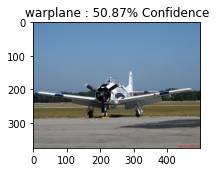

405


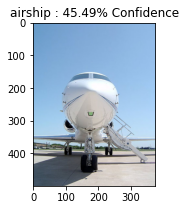

404


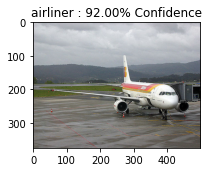

In [ ]:
for ind, key in enumerate(src_keys[0:3]):
  img = D.val_data_cl[key]['X']
  image = preprocess(img)
  image_probs = pretrained_model.predict(image)

  print(np.argmax(image_probs))   # airliner: 404

  plt.figure(figsize=(3,3))
  plt.imshow(D.val_data_cl[key]['X'])
  _, image_class, class_confidence = get_imagenet_label(image_probs)
  plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
  plt.show()

628


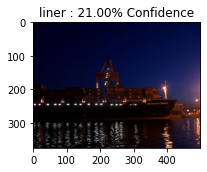

628


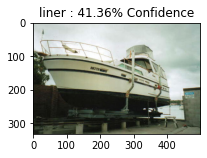

536


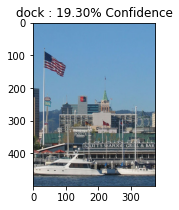

In [ ]:
for ind, key in enumerate(trg_keys[0:3]):
  img = D.val_data_cl[key]['X']
  image = preprocess(img)
  image_probs = pretrained_model.predict(image)

  print(np.argmax(image_probs))   # Liner: 628

  plt.figure(figsize=(3,3))
  plt.imshow(D.val_data_cl[key]['X'])
  _, image_class, class_confidence = get_imagenet_label(image_probs)
  plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
  plt.show()


**FGSM:**

Create target label

In [ ]:
trg_index = 628
label = tf.one_hot(trg_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(src_image, trg_label):

  img = preprocess(src_image)
  
  with tf.GradientTape() as tape:
    tape.watch(img)
    prediction = pretrained_model(img)
    loss = loss_object(trg_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, img)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad


The resulting perturbations can also be visualised (for a selected image):

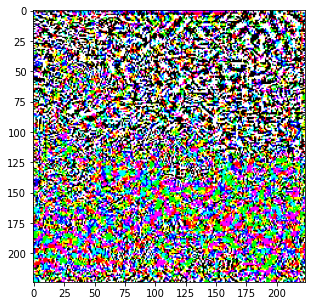

In [ ]:
img = D.val_data_cl[trg_keys[2]]['X']

perturbations = create_adversarial_pattern(img, label)
plt.figure(figsize=(5,5))
plt.imshow(perturbations[0]*0.5+0.5); # To change [-1, 1] to [0,1]

Let's try this out for different values of epsilon and observe the resultant image. You'll notice that as the value of epsilon is increased, it becomes easier to fool the network. However, this comes as a trade-off which results in the perturbations becoming more identifiable.

In [ ]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

In [ ]:

for img_id in range(10):
  img = D.val_data_cl[trg_keys[img_id]]['X']

  epsilons = [0, 0.01, 0.1, 0.15]
  descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

  for i, eps in enumerate(epsilons):
    adv_x = preprocess(img) + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    display_images(adv_x, descriptions[i])

### **Adversarial Examples - Auto-Encoder**

Architecture AE based on: https://www.datacamp.com/community/tutorials/autoencoder-keras-tutorial

Added:

* Extra deep layer (in encoder & decoder)
* Batch Normalization (of each conv2D layer)


In [ ]:
import tensorflow
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D,Dense,Flatten,add,BatchNormalization,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [ ]:
IMG_SIZE = 224
channels = 3

input_img = Input(shape = (IMG_SIZE, IMG_SIZE, channels))

In [ ]:
def autoencoder(input_img, use_batch_normalization=True):
    #input = IMG_SIZE x IMG_SIZE x 3

    #encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) # 224x224x32
    if use_batch_normalization:
      conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)     # 112x112x64
    if use_batch_normalization:
      conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) 
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)    # 56x56x128
    if use_batch_normalization:
      conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) 
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)    # 28x28x256
    if use_batch_normalization:
      conv4 = BatchNormalization()(conv4)

    #decoder
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)    # 28x28x256
    if use_batch_normalization:
      conv5 = BatchNormalization()(conv5)
    up1 = UpSampling2D((2,2))(conv5)
    conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up1)      # 56x56x128
    if use_batch_normalization:
      conv6 = BatchNormalization()(conv6)
    up2 = UpSampling2D((2,2))(conv6) 
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up2)       # 112x112x64
    if use_batch_normalization:
      conv7 = BatchNormalization()(conv7)
    up3 = UpSampling2D((2,2))(conv7)
    decoded = Conv2D(3, (3, 3), activation='tanh', padding='same')(up3)   # 224x224x32        # tanh might be more appropriate than sigmoid
    return decoded

autoencoder1 = Model(input_img, autoencoder(input_img))
autoencoder1.compile(loss='mean_squared_error', optimizer = Adam(learning_rate=0.0001))

autoencoder1.summary()
#tensorflow.keras.utils.plot_model(autoencoder1, show_shapes=True, show_layer_names=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0     

**Learn Identity Mapping - Reconstruction:**

* Small experiment to get some intuition on how the auto-encoder behaves.
* It seems to be able to very well reconstruct the images presented at the input, with very good generalizability towards the validation set.

Note: this is not what we want the AE to learn, indeed, the AE should learn how to optimally perturbe images and output these perturbations.

In [ ]:
batch_size = 32
epochs = 5

autoencoder1_hist = autoencoder1.fit(X_train, X_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_val, X_val))

In [ ]:
#%cd '/content/drive/My Drive/CV3_Deep_Learning_files/'
#np.save('ae1_hist.npy',autoencoder1_hist.history)
#autoencoder1.save_weights('model_weights_ae1.h5')

#autoencoder1.load_weights('/content/drive/My Drive/CV3_Deep_Learning_files/model_weights_ae1.h5')
#ae1_hist=np.load('/content/drive/My Drive/CV3_Deep_Learning_files/ae1_hist.npy',allow_pickle='TRUE').item()

**Define Classifier network, load weights (gdrive) & freeze all layers:**

In [ ]:
IMG_SIZE = 224
channels = 3

# Define classification model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
ap = GlobalAveragePooling2D()(base_model.output)
fc1 = Dense(512, activation='relu')(ap)
bn = BatchNormalization()(fc1)
d = Dropout(0.3)(bn)
output = Dense(20, activation='sigmoid')(d)
model = Model(inputs=base_model.inputs, outputs=output)

classifier_model = Model(inputs=base_model.inputs, outputs=output, name='classifier_densenet')
classifier_model.load_weights('/content/drive/My Drive/CV3_Deep_Learning_files/model_weights_TL_cl_valF1_80.h5')

for layer in classifier_model.layers:
	layer.trainable = False

**Define AE but now with additional final layer:**
 

In [ ]:
input_img = Input(shape = (IMG_SIZE, IMG_SIZE, channels), name='input')
use_batch_normalization=True

#encoder
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) # 224x224x32
if use_batch_normalization:
    conv1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)     # 112x112x64
if use_batch_normalization:
    conv2 = BatchNormalization()(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) 
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)    # 56x56x128
if use_batch_normalization:
    conv3 = BatchNormalization()(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) 
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)    # 28x28x256
if use_batch_normalization:
    conv4 = BatchNormalization()(conv4)

#decoder
conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)    # 28x28x256
if use_batch_normalization:
    conv5 = BatchNormalization()(conv5)
up1 = UpSampling2D((2,2))(conv5)
conv6 = Conv2D(128, (3, 3), activation='relu', padding='same')(up1)      # 56x56x128
if use_batch_normalization:
    conv6 = BatchNormalization()(conv6)
up2 = UpSampling2D((2,2))(conv6) 
conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up2)       # 112x112x64
if use_batch_normalization:
    conv7 = BatchNormalization()(conv7)
up3 = UpSampling2D((2,2))(conv7)
delta = Conv2D(3, (3, 3), activation='linear', padding='same', name="delta")(up3)     # 224x224x32

Define AE model, Add perturbations (output) to input image

In [ ]:
autoencoder_model = Model(inputs=input_img, outputs=delta)
#autoencoder_model.load_weights('/content/drive/My Drive/CV3_Deep_Learning_files/model_weights_autoencoder_AE.h5') # OPTIONAL

perturbed_img = add([autoencoder_model.output, input_img], name="perturbed_img")
class_model = classifier_model(perturbed_img)

**Merge AE and Classifier:**

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 224, 224, 32) 896         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_23 (BatchNo (None, 224, 224, 32) 128         conv2d_22[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 112, 112, 32) 0           batch_normalization_23[0][0]     
___________________________________________________________________________________________

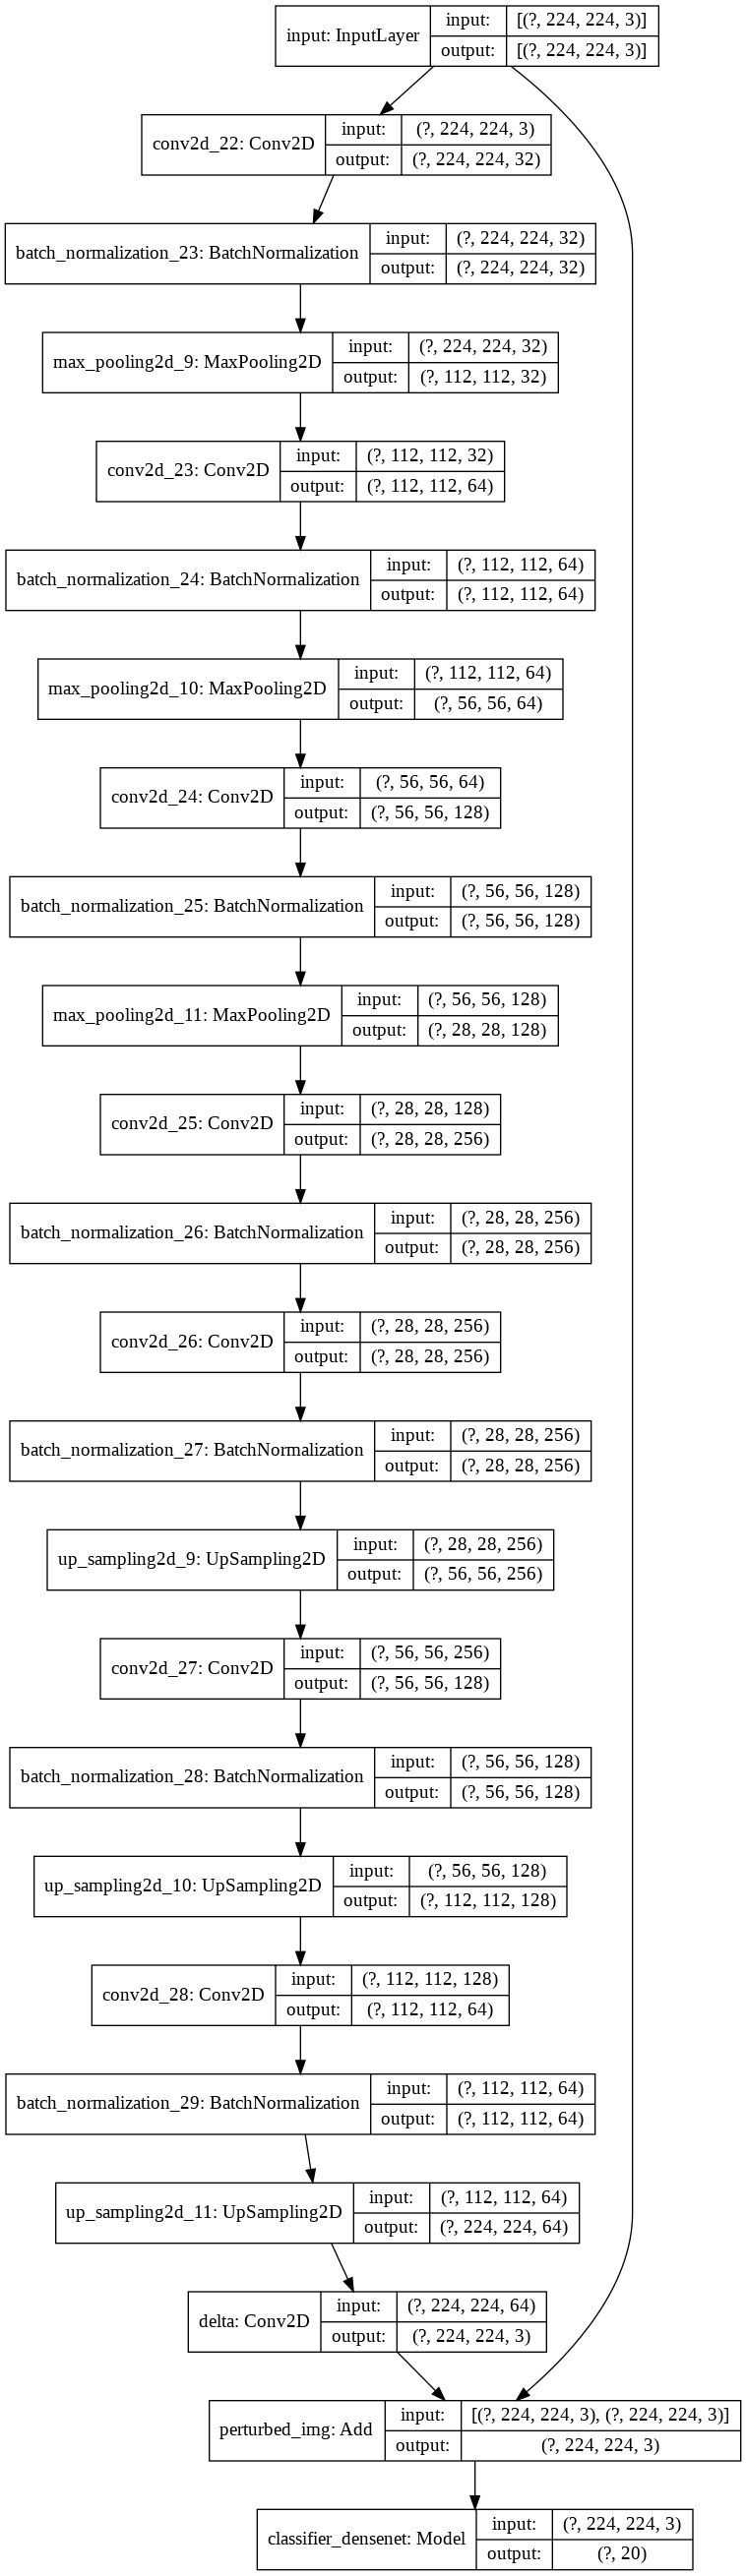

In [ ]:
merged_model = Model(inputs=[input_img], outputs=[delta, class_model],)
merged_model_augm = Model(inputs=[input_img], outputs=[delta, class_model],)

merged_model.summary()
tf.keras.utils.plot_model(merged_model, show_shapes=True)

Define Generator Wrapper & Custom loss (for Multi-Output model)

In [ ]:
def generator_wrapper(generator, X, delta, Y, bs):
    genXY = generator.flow(X, Y, seed=11, batch_size=bs)
    genDelta = generator.flow(delta, seed=11, batch_size=bs)
    while True:
        X, Y = genXY.next()
        delta = genDelta.next()
        yield X, [delta, Y]  # bX, [bDelta, bY]


from tensorflow.keras.backend import zeros as tf_zeros
    
# Define custom loss function
#def custom_loss_wrapper(lamb):
#    def custom_loss(y_true, y_pred):
#        x_src, y_tr = y_true[0], y_true[1]
#        x_perturb, y_pr = y_pred[0], y_pred[1]
#        K.print_tensor(K.mean(K.sqrt(K.sum(K.pow(x_perturb, 2)))), message='K_mean = ')
#        return lamb*(K.mean(K.sqrt(K.sum(K.pow(x_perturb, 2))))) + K.mean(K.binary_crossentropy(y_tr, y_pr))
#    return custom_loss

    # Define custom loss function
def custom_loss_wrapper(lamb):
    def custom_loss(y_true, y_pred):
        x_src, y_tr = y_true[0], y_true[1]
        x_perturb, y_pr = y_pred[0], y_pred[1]
        return K.mean(K.square(x_perturb))*lamb + K.mean(K.binary_crossentropy(y_tr, y_pr))
    return custom_loss

Compile model - Choose Loss:

In [ ]:
REG_HYPERPAR = 0.05

# w data augmentation
merged_model_augm.compile(optimizer=Adam(lr=1e-4),
                          loss=custom_loss_wrapper(REG_HYPERPAR),
                          metrics=['accuracy'])

# wo data augmentation
merged_model.compile(optimizer=Adam(lr=1e-4),
                     loss=custom_loss_wrapper(REG_HYPERPAR),
                     metrics=['accuracy'])

Define Training/Validation data & labels:

* source class (src_class): the class of images we want to perturb
* target class (trg_class): the class we want the classifier to wrongly label the source class

Note: For simplicity, only images with the presence of only the source class and only the target class are considered <br>
(see definition *get_src_trg_keys()*)

In [ ]:
src_class = 'cat'
trg_class = 'dog'

src_keys_train, trg_keys_train = get_src_trg_keys(src_class, trg_class, 'training')
src_keys_val, trg_keys_val = get_src_trg_keys(src_class, trg_class, 'validation')

Load Images as numpy stacks (and resample + preprocess):

In [ ]:
from tensorflow.keras.applications.imagenet_utils import preprocess_input

def get_class_specific_X_y_and_preproc(keys,set='validation',size=224, chan=3):
  X, y = np.zeros((len(keys), size, size, chan), dtype=np.float32), np.zeros((1, 20), dtype=np.float32)
  if set == 'validation':
    for i,key in enumerate(keys):
      X[i] = preprocess_input(cv2.resize(D.val_data_cl[key]['X'], (size,size), interpolation=cv2.INTER_LINEAR), 'channels_last', 'torch')        # Resample & Preproc                                             
    y[:] = D.val_data_cl[key]['y']
  elif set == 'training':
    for i,key in enumerate(keys):
      X[i] = preprocess_input(cv2.resize(D.train_data_cl[key]['X'], (size,size), interpolation=cv2.INTER_LINEAR), 'channels_last', 'torch')       # Resample & Preproc                                                                  # Preprocess
    y[:] = D.train_data_cl[key]['y']
  return X, y

src_train_X, _ = get_class_specific_X_y_and_preproc(src_keys_train,'training',224,3)
_, trg_train_y = get_class_specific_X_y_and_preproc(trg_keys_train,'training',224,3)

src_val_X, _ = get_class_specific_X_y_and_preproc(src_keys_val,'validation',224,3)
_, trg_val_y = get_class_specific_X_y_and_preproc(trg_keys_val,'validation',224,3)


Define Data Generators:

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

train_datagen = ImageDataGenerator(zoom_range=0.2,
                                   horizontal_flip=True,
                                   rotation_range=20,
                                   shear_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2)
test_datagen = ImageDataGenerator()

Early_Stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=50,
    mode='min',
    restore_best_weights=True)

Train Complete Network (w/o and w data augmentation):

In [ ]:
NUM_EPOCHS = 100
BATCH_SIZE = 16

trg_train_ys = np.repeat(trg_train_y,len(src_train_X),axis=0)
trg_val_ys = np.repeat(trg_val_y,len(src_val_X),axis=0)

num_src_train_images = len(src_train_X)
num_src_val_images = len(src_val_X)
delta_train = np.zeros((num_src_train_images,224,224,3),dtype=np.float32)
delta_val = np.zeros((num_src_val_images,224,224,3),dtype=np.float32)

#print("AUGMENTATION\n\n")
#mm_augm_hist = merged_model_augm.fit(generator_wrapper(train_datagen, src_train_X, delta_train trg_train_ys, BATCH_SIZE),
#                                     steps_per_epoch=num_src_train_images // BATCH_SIZE,
#                                     validation_data=generator_wrapper(test_datagen, src_val_X, delta_val, trg_val_ys, BATCH_SIZE),
#                                     validation_steps=(len(trg_val_ys) // BATCH_SIZE),
#                                     epochs=NUM_EPOCHS)

print("WO AUGMENTATION\n\n")
mm_hist = merged_model.fit(src_train_X,
                           {'delta': delta_train, 'classifier_densenet': trg_train_ys},
                           validation_data=(src_val_X,
                           {'delta': delta_val, 'classifier_densenet': trg_val_ys}),
                           epochs=NUM_EPOCHS,
                           steps_per_epoch=num_src_train_images // BATCH_SIZE,
                           batch_size=BATCH_SIZE)


WO AUGMENTATION


Epoch 1/100
12/12 [==============================] - 11s 895ms/step - loss: 3.8704 - delta_loss: 3.6841 - classifier_densenet_loss: 0.1862 - delta_accuracy: 0.3620 - classifier_densenet_accuracy: 0.1302 - val_loss: 0.4194 - val_delta_loss: 0.0021 - val_classifier_densenet_loss: 0.4173 - val_delta_accuracy: 0.0033 - val_classifier_densenet_accuracy: 0.0730
Epoch 2/100
12/12 [==============================] - 8s 681ms/step - loss: 3.4208 - delta_loss: 3.2250 - classifier_densenet_loss: 0.1959 - delta_accuracy: 0.3475 - classifier_densenet_accuracy: 0.1702 - val_loss: 0.4293 - val_delta_loss: 0.0012 - val_classifier_densenet_loss: 0.4281 - val_delta_accuracy: 0.0014 - val_classifier_densenet_accuracy: 0.0730
Epoch 3/100
12/12 [==============================] - 8s 675ms/step - loss: 3.1662 - delta_loss: 2.9747 - classifier_densenet_loss: 0.1915 - delta_accuracy: 0.3447 - classifier_densenet_accuracy: 0.2500 - val_loss: 0.4360 - val_delta_loss: 0.0026 - val_classifier_dens

Saving/Loading the trained models:

In [ ]:
#%cd '/content/drive/My Drive/CV3_Deep_Learning_files/'

#np.save('AE_mm_hist.npy',mm_hist.history)
#merged_model.save_weights('model_weights_AE_mm.h5')

#np.save('AE_mm_augm_hist.npy',mm_augm_hist.history)
#merged_model_augm.save_weights('model_weights_AE_mm_augm.h5')

#merged_model.load_weights('/content/drive/My Drive/CV3_Deep_Learning_files/model_weights_AE_mm.h5')
#merged_model_augm.load_weights('/content/drive/My Drive/CV3_Deep_Learning_files/model_weights_AE_mm_augm.h5')

/content/drive/My Drive/CV3_Deep_Learning_files


Visualizing the Loss and Performance (throughout training):

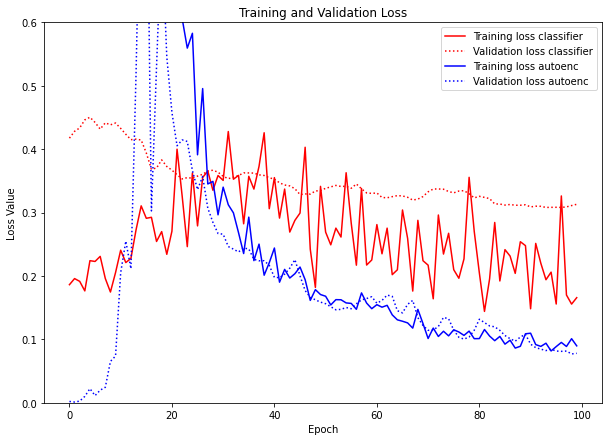

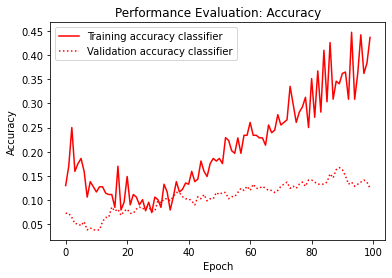

In [ ]:
# Non-augmented Training:
loss = mm_hist.history['classifier_densenet_loss']
val_loss = mm_hist.history['val_classifier_densenet_loss']
delta_loss = mm_hist.history['delta_loss']
delta_val_loss = mm_hist.history['val_delta_loss']

acc = mm_hist.history['classifier_densenet_accuracy']
val_acc = mm_hist.history['val_classifier_densenet_accuracy']
delta_acc = mm_hist.history['delta_accuracy']
delta_val_acc = mm_hist.history['val_delta_accuracy']


# Augmented Training:
loss_augm = mm_augm_hist.history['classifier_densenet_loss']
val_loss_augm = mm_augm_hist.history['val_classifier_densenet_loss']
delta_loss_augm = mm_augm_hist.history['delta_loss']
delta_val_loss_augm = mm_augm_hist.history['val_delta_loss']

acc_augm = mm_augm_hist.history['classifier_densenet_accuracy']
val_acc_augm = mm_augm_hist.history['val_classifier_densenet_accuracy']
delta_acc_augm = mm_augm_hist.history['delta_accuracy']
delta_val_acc_augm = mm_augm_hist.history['val_delta_accuracy']

epochs1 = range(NUM_EPOCHS)[:len(loss)]
epochs2 = range(NUM_EPOCHS)[:len(loss_augm)]


plt.figure(figsize=(10,7))
plt.plot(epochs1, loss, 'r', label='Training loss classifier')
plt.plot(epochs1, val_loss, 'r:', label='Validation loss classifier')
plt.plot(epochs1, delta_loss, 'b', label='Training loss autoenc')
plt.plot(epochs1, delta_val_loss, 'b:', label='Validation loss autoenc')

#plt.plot(epochs2, loss_augm, 'g', label='Training loss classifier - Augm')
#plt.plot(epochs2, val_loss_augm, 'g:', label='Validation loss classifier - Augm')
#plt.plot(epochs2, delta_loss_augm, 'm', label='Training loss autoenc - Augm')
#plt.plot(epochs2, delta_val_loss_augm, 'm:', label='Validation loss autoenc - Augm')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim(0,0.6)
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs1, acc, 'r', label='Training accuracy classifier')
plt.plot(epochs1, val_acc, 'r:', label='Validation accuracy classifier')
#plt.plot(epochs2, acc_augm, 'g', label='Training accuracy classifier - Augm')
#plt.plot(epochs2, val_acc_augm, 'g:', label='Validation accuracy classifier - Augm')

plt.title('Performance Evaluation: Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#AE_mm_hist=np.load('/content/drive/My Drive/CV3_Deep_Learning_files/AE_mm_hist.npy',allow_pickle='TRUE').item()
#AE_mm_augm_hist=np.load('/content/drive/My Drive/CV3_Deep_Learning_files/AE_mm_augm_hist.npy',allow_pickle='TRUE').item()

# Non-augmented Training:
loss = AE_mm_hist['loss']
val_loss = AE_mm_hist['val_loss']

#acc = AE_mm_hist['accuracy']
#val_acc = AE_mm_hist.history['val_accuracy']

# Augmented Training:
loss_augm = AE_mm_augm_hist['loss']
val_loss_augm = AE_mm_augm_hist['val_loss']

#acc_augm = AE_mm_augm_hist['accuracy']
#val_acc_augm = AE_mm_augm_hist['val_accuracy']


epochs1 = range(NUM_EPOCHS)[:len(loss)]
epochs2 = range(NUM_EPOCHS)[:len(loss_augm)]

plt.figure()
plt.plot(epochs1, loss, 'r', label='Training loss')
plt.plot(epochs1, val_loss, 'r:', label='Validation loss')
plt.plot(epochs2, loss_augm, 'b', label='Training loss - Augm')
plt.plot(epochs2, val_loss_augm, 'b:', label='Validation loss - Augm')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs1, acc, 'r', label='Training accuracy')
plt.plot(epochs1, val_acc, 'r:', label='Validation accuracy')
plt.plot(epochs2, acc_augm, 'b', label='Training accuracy - Augm')
plt.plot(epochs2, val_acc_augm, 'b:', label='Validation accuracy - Augm')
plt.title('Performance Evaluation: Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

NameError: ignored

Observations: <br>

* Clear overfitting without data augmentation. 
* In general no good generalization towards the validation set (improve loss function!). 
* Slow learning with data augmentation.

**Interesting References + Summary:**

* https://www.tensorflow.org/tutorials/generative/adversarial_fgsm

* https://towardsdatascience.com/breaking-machine-learning-with-adversarial-examples-a3ddc5c75ea4

* https://medium.com/@ml.at.berkeley/tricking-neural-networks-create-your-own-adversarial-examples-a61eb7620fd8


<br>

--------------------------Non-Targeted vs Targeted Attack (DESIRED):------------------------------------

<br>

* former: will look mostly like noise to human observers (l** = 0.5*||(y_goal - y_pred(x))^2||)
* latter: require perturbed image to closely resemble original image 

<br>

  * technique 1: regularization in loss (loss = l** + lambda*||(x - x_target)^2||)
  * technique 2: limit perturbation with epsilon


**To Improve / Investigate (in order of importance):**

* **Customized, Regularized Loss:** For the moment, the size of the perturbations is limited by the parameters *eps*, however, as suggested in the assignment this could also (and probably better) be optimized by incorporating a regularization term in the loss function (such as L2 norm on delta multiplied with hyperparameter lambda). 

* **Training of the Model:** Getting better understanding of the training process of the model and the impact of the training parameters, considering especially the smaller training set. Also investigate in more depth the impact of data augmentation. These aspects are also related to selection of source/target class (and their sizes).

* **Initialization weights AE:** The autoencoder is trained from scratch, whith randomly initialized interconnection weights. Therefore results and learning process might differ remarkably from one experiment to another. It might be interesting to look at the impact of initializing the AE network weights with the weights obtained through unsupervised training of the AE (learning the identity mapping). Indeed, if the images are reconstructed very well by the AE and this generalizes to the test set, then it seems reasonable that the encoder part indeed extracts meaningful features from the images from which the decoder can then reconstruct the original image.


# Discussion